<h3> Using the IMDB dataset we will import the data in a mongo db instance and perform some basic analysis on the data. </h3>

In [2]:
#connect to mongodb instance using pymongo
import pymongo
import json
import pandas as pd
#we will use seaborn and pyplot to visualize the data in the mongo node
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#server is at localhost:27017
client = pymongo.MongoClient("localhost", 27017)

In [4]:
#create new mongodb database named imdb
db = client.imdb
#keep in mind nothing is stored in the database until you insert something

In [4]:
#read name_basics.json file and insert into mongodb in a new collection named name_basics

name_basics_json = []

#we need to load the json file into a list of dictionaries
#we can use the json module to load the file, keep in mind the file is not utf-8 encoded

with open("name_basics.json",encoding='utf-8') as f:
    name_basics_json = json.load(f)

#replace $oid with _id to fix error : _id fields may not contain '$'-prefixed fields: $oid is not valid for storage
name_basics_fixed_id = []
for i in name_basics_json:
    i['_id'] = i['_id']['$oid']
    name_basics_fixed_id.append(i)

#empty collection
db.name_basics.delete_many({})
#insert into collection
db.name_basics.insert_many(name_basics_fixed_id)
#clear the arrays because we don't need them anymore and they are quite large
name_basics_json = []
name_basics_fixed_id = []


<p> Interesting benchmarking results:
<ul> 
<li> JSON loading took approx: 7.5 minutes </li>
<li> Clearing the database from prexisting data 8 minutes </li>
<li> Loading the data into the database took approx: 10 minutes </li>
</ul>
</p>

In [5]:
#create new collection named title_basics

#load title_2basics.json file
title_basics_json = []
with open("title2_basics.json",encoding='utf-8') as f:
    title_basics_json = json.load(f)
#replace $oid with _id to fix error : _id fields may not contain '$'-prefixed fields: $oid is not valid for storage
title_basics_fixed_id = []
for i in title_basics_json:
    i['_id'] = i['_id']['$oid']
    title_basics_fixed_id.append(i)
#empty collection
db.title_basics.delete_many({})
#insert into collection
db.title_basics.insert_many(title_basics_fixed_id)
#clear the arrays because we don't need them anymore and they are quite large
title_basics_json = []
title_basics_fixed_id = []

<p><i>All the data has been loaded to the database , now we can proceed to the analysis</i></p>

In [5]:

size_name_basics = db.name_basics.count_documents({})
size_title_basics = db.title_basics.count_documents({})

#print the size of the collections
print("size of name_basics: ", size_name_basics)
print("size of title_basics: ", size_title_basics)



size of name_basics:  11356011
size of title_basics:  8460719


In [8]:
#print the first 2 documents in the name_basics collection and the first 2 documents in the title_basics collection
title_collection = db.title_basics
print(title_collection.find_one())
names_collection = db.name_basics
print(names_collection.find_one())


{'_id': '619a196745a480077f68b8ab', 'tconst': 'tt0000001', 'titleType': 'short', 'primaryTitle': 'Carmencita', 'originalTitle': 'Carmencita', 'isAdult': 0, 'startYear': 1894, 'endYear': 2021, 'runtimeMinutes': 1, 'genres': ['Documentary', 'Short'], 'averageRating': 5.7, 'numVotes': 1836}
{'_id': '619a1b3545a480077fe9d25a', 'nconst': 'nm0000001', 'primaryName': 'Fred Astaire', 'birthYear': 1899, 'deathYear': 1987, 'primaryProfession': ['soundtrack', 'actor', 'miscellaneous'], 'knownForTitles': ['tt0050419', 'tt0031983', 'tt0053137', 'tt0072308']}


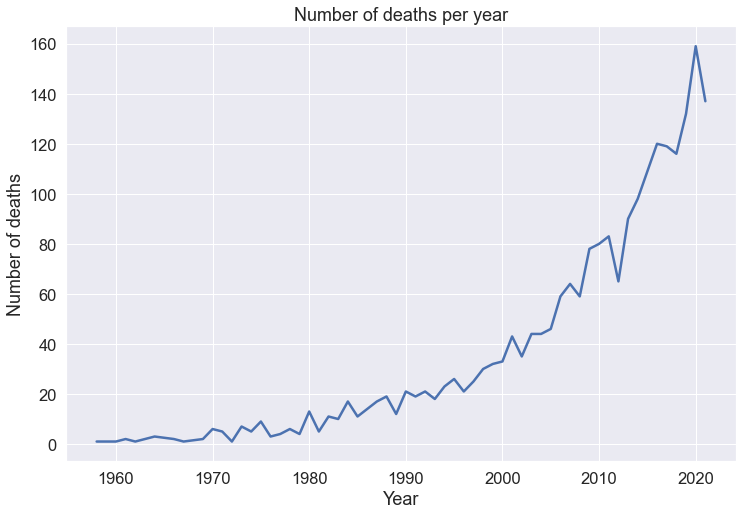

In [11]:


#find all the directors in the names_collection born on 1939 , 'primaryName' is the name and 'birthYear' is the year they were born
directors = names_collection.find({'birthYear':1939})
#create new dataframe with 2 columns 'Name' and 'Death Year'
directors_df = pd.DataFrame(columns=['Name','Death Year'])
#iterate through the directors and add them to the dataframe
for i in directors:
    directors_df.loc[len(directors_df)] = [i['primaryName'],i['deathYear']]

#create a count of deaths per year
deaths = directors_df.groupby('Death Year').count()
#plot the count of deaths per year

plt.figure(figsize=(12, 8))
plt.title("Number of deaths per year")
plt.xlabel("Year")
plt.ylabel("Number of deaths")
plt.plot(deaths)
plt.show()



          Title  Average Rating  Number of Votes
0  Episode #1.1            10.0              283
1  Episode #1.7            10.0              238
2    Ozymandias            10.0           147294
3      Face Off             9.9            51927
4        Felina             9.9            99932
5         Paatr             9.9              400


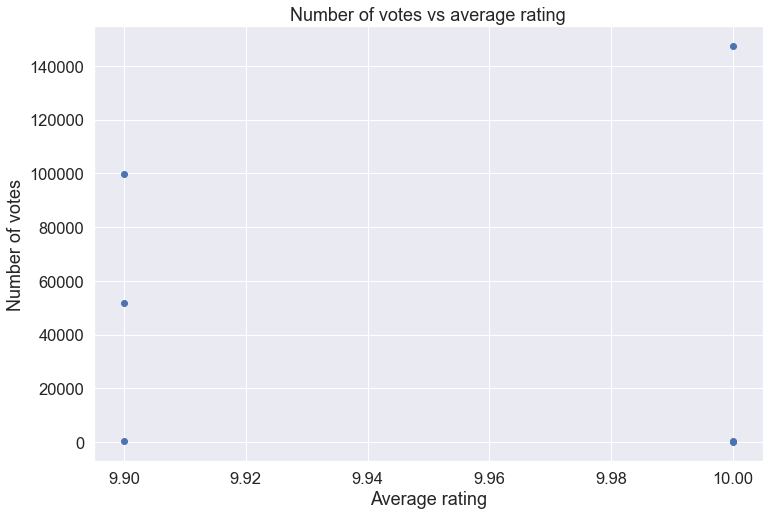

In [15]:
#find the 6 highest rated thriller movies with at least 100 ratings (the movies are in the title_collection) thriller must be in the genres list, averageRating is the rating and numVotes is the number of votes
top_rated_thrillers = title_collection.find({'genres':'Thriller','numVotes':{'$gte':100}}).sort('averageRating',-1).limit(6)
#create new dataframe with 3 columns 'Title','Average Rating','Number of Votes'
top_rated_thrillers_df = pd.DataFrame(columns=['Title','Average Rating','Number of Votes'])
#iterate through the top_rated_thrillers and add them to the dataframe
for i in top_rated_thrillers:
    top_rated_thrillers_df.loc[len(top_rated_thrillers_df)] = [i['primaryTitle'],i['averageRating'],i['numVotes']]
print(top_rated_thrillers_df)
#scatter plot ,y = number of votes x= average rating
plt.figure(figsize=(12, 8))
plt.title("Number of votes vs average rating")
plt.xlabel("Average rating")
plt.ylabel("Number of votes")
plt.scatter(top_rated_thrillers_df['Average Rating'],top_rated_thrillers_df['Number of Votes'])
plt.show()



                          Title  Start Year  End Year  Duration  \
0                    This Is Us        2016      2022         6   
1                         Ozark        2017      2022         5   
2              Better Call Saul        2015      2022         7   
3               Attack on Titan        2013      2022         9   
4              The Walking Dead        2010      2022        12   
5            Gone with the Wind        1939      2021        82   
6                   City Lights        1931      2021        90   
7  Mr. Smith Goes to Washington        1939      2021        82   
8                             M        1931      2021        90   
9              The Wizard of Oz        1939      2021        82   

   Number of Votes  Average Rating  
0           120388             8.6  
1           218048             8.4  
2           363776             8.8  
3           259022             9.0  
4           912189             8.2  
5           303081             8.1  
6  

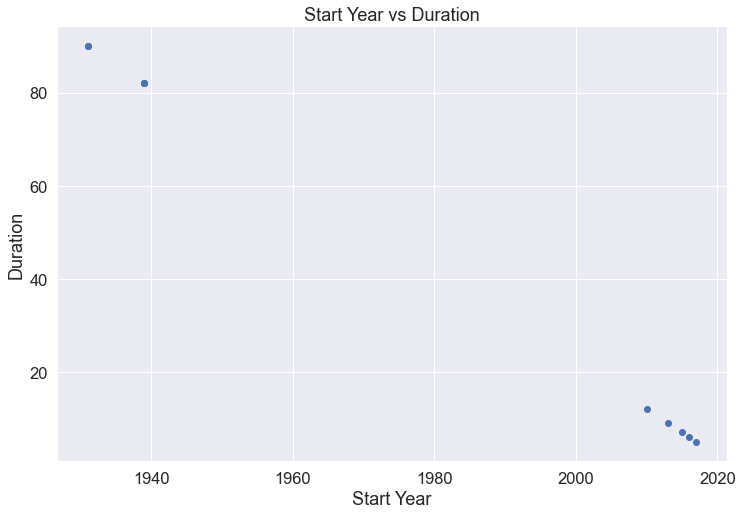

In [16]:
#find the 10 most long lasting tvSeries with at least 100000 votes and print the title and the age in descending order, use the current year for the calculation of the duration, if a tvSeries doesn't have a endYear, use the current year
tvSeries = title_collection.find({'$and':[{'numVotes':{'$gte':100000}},{'$or':[{'endYear':{'$exists':True}},{'endYear':{'$exists':False}}]}]}).sort('endYear',-1).limit(10)
#create new dataframe with 6 columns 'Title','Start Year','End Year','Duration','Number of Votes','Average Rating'
tvSeries_df = pd.DataFrame(columns=['Title','Start Year','End Year','Duration','Number of Votes','Average Rating'])
#iterate through the tvSeries and add them to the dataframe
for i in tvSeries:
    if i['endYear'] == None:
        i['endYear'] = datetime.datetime.now().year
    tvSeries_df.loc[len(tvSeries_df)] = [i['primaryTitle'],i['startYear'],i['endYear'],i['endYear']-i['startYear'],i['numVotes'],i['averageRating']]
print(tvSeries_df)

#plot Start Year vs Duration
plt.figure(figsize=(12, 8))
plt.title("Start Year vs Duration")
plt.xlabel("Start Year")
plt.ylabel("Duration")
plt.scatter(tvSeries_df['Start Year'],tvSeries_df['Duration'])
plt.show()


                              Genre   Count
0                           [Drama]  837418
1                          [Comedy]  545995
2                       [Talk-Show]  489171
3                            [News]  408783
4                     [Documentary]  382093
...                             ...     ...
2210                 [Musical, War]       1
2211      [News, Sci-Fi, Talk-Show]       1
2212      [Crime, Romance, Western]       1
2213  [Documentary, Music, Western]       1
2214    [Documentary, Mystery, War]       1

[2215 rows x 2 columns]


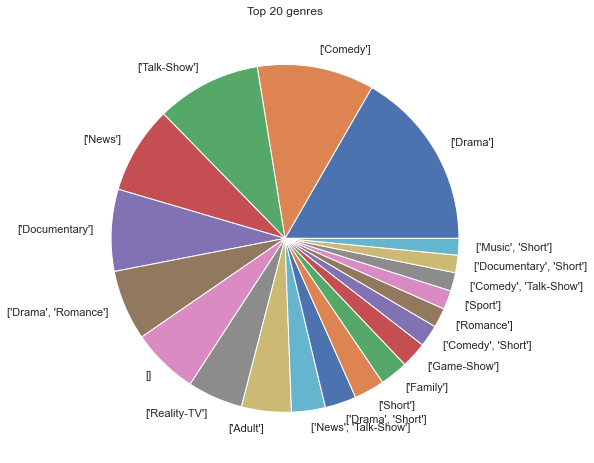

In [27]:
#find the count of movies by genre and the average rating for all movies after 1980 , sort by the count of movies by genre 
#keep in mind genre is a list so we need to check individual genres
genre_count = title_collection.aggregate([{'$match':{'startYear':{'$gte':1980}}},{'$group':{'_id':'$genres','count':{'$sum':1}}},{'$sort':{'count':-1}}])
#create new dataframe with 2 columns 'Genre','Count'
genre_count_df = pd.DataFrame(columns=['Genre','Count'])
#iterate through the genre_count and add them to the dataframe
for i in genre_count:
    genre_count_df.loc[len(genre_count_df)] = [i['_id'],i['count']]
print(genre_count_df)


#create a pie chart showing the top 20 genres
plt.figure(figsize=(12, 8))
plt.title("Top 20 genres")
plt.pie(genre_count_df['Count'].head(20),labels=genre_count_df['Genre'].head(20))
plt.show()



                           Genre  Count
0           [Documentary, Short]   4773
1                        [Short]   1391
2                [Comedy, Short]    740
3    [Documentary, Short, Sport]    266
4                  [News, Short]    165
..                           ...    ...
70    [Family, Fantasy, Romance]      1
71  [Animation, Comedy, Romance]      1
72       [Comedy, Family, Short]      1
73       [Comedy, Sci-Fi, Short]      1
74               [Action, Short]      1

[75 rows x 2 columns]


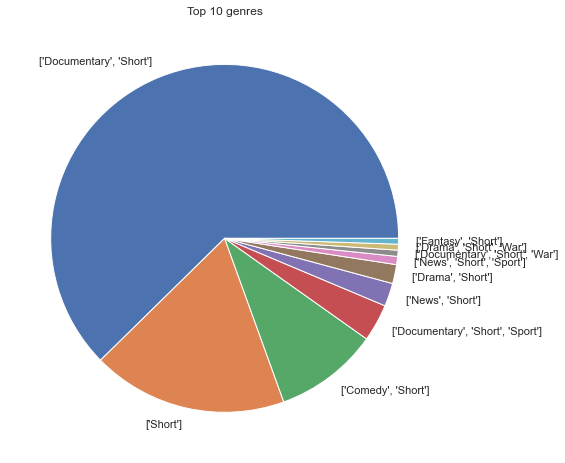

In [30]:
#find the movies created in the 19th century and sort them by the highest counted genre , one genre at a time , descending order
century_movies = title_collection.aggregate([{'$match':{'startYear':{'$gte':1800,'$lte':1900}}},{'$group':{'_id':'$genres','count':{'$sum':1}}},{'$sort':{'count':-1}}])
#create new dataframe with 2 columns 'Genre','Count'
century_movies_df = pd.DataFrame(columns=['Genre','Count'])
#iterate through the century_movies and add them to the dataframe
for i in century_movies:
    century_movies_df.loc[len(century_movies_df)] = [i['_id'],i['count']]
print(century_movies_df)
#create a pie chart showing the top 20 genres
plt.figure(figsize=(15, 8))
plt.title("Top 10 genres")
plt.pie(century_movies_df['Count'].head(10),labels=century_movies_df['Genre'].head(10))
plt.show()


In [38]:
#now we are going to optimize the collections by setting the appropriate indexes
#to figure out what indexes are needed, we will use the explain command

#lets find the best indexes for the title_collection by using the explain command on different queries and see which indexes are needed
explain_title_collection = title_collection.find({'primaryTitle':'The Shawshank Redemption'}).explain()
print(explain_title_collection)
#we need to create an index on the primaryTitle field
title_collection.create_index([('primaryTitle', pymongo.ASCENDING)])
#check numVotes and averageRating explain command
explain_numVotes = title_collection.find({'numVotes':{'$gte':100}}).explain()
print(explain_numVotes)
#we need to create an index on the numVotes field
title_collection.create_index([('numVotes', pymongo.ASCENDING)])
#check averageRating explain command
explain_averageRating = title_collection.find({'averageRating':{'$gte':7}}).explain()
print(explain_averageRating)
#we dont need to create an index on the averageRating field 
#we can also create an index on the startYear field
title_collection.create_index([('startYear', pymongo.ASCENDING)])

#now the names_collection
#lets find the best indexes for the names_collection by using the explain command on different queries and see which indexes are needed
#lets try primaryTitle with a name of a director
explain_names_collection = names_collection.find({'primaryName':'Steven Spielberg'}).explain()
print(explain_names_collection)
#we need to create an index on the primaryName field
names_collection.create_index([('primaryName', pymongo.ASCENDING)])
#check primaryProfession
explain_primaryProfession = names_collection.find({'primaryProfession':'soundtrack'}).explain()
print(explain_primaryProfession)
#we need to create an index on the primaryProfession field
names_collection.create_index([('primaryProfession', pymongo.ASCENDING)])
#check birthYear
explain_birthYear = names_collection.find({'birthYear':{'$gte':1930}}).explain()
print(explain_birthYear)
#we need to create an index on the birthYear field
names_collection.create_index([('birthYear', pymongo.ASCENDING)])






{'explainVersion': '1', 'queryPlanner': {'namespace': 'imdb.title_basics', 'indexFilterSet': False, 'parsedQuery': {'primaryTitle': {'$eq': 'The Shawshank Redemption'}}, 'maxIndexedOrSolutionsReached': False, 'maxIndexedAndSolutionsReached': False, 'maxScansToExplodeReached': False, 'winningPlan': {'stage': 'FETCH', 'inputStage': {'stage': 'IXSCAN', 'keyPattern': {'primaryTitle': 1}, 'indexName': 'primaryTitle_1', 'isMultiKey': False, 'multiKeyPaths': {'primaryTitle': []}, 'isUnique': False, 'isSparse': False, 'isPartial': False, 'indexVersion': 2, 'direction': 'forward', 'indexBounds': {'primaryTitle': ['["The Shawshank Redemption", "The Shawshank Redemption"]']}}}, 'rejectedPlans': []}, 'executionStats': {'executionSuccess': True, 'nReturned': 7, 'executionTimeMillis': 16, 'totalKeysExamined': 7, 'totalDocsExamined': 7, 'executionStages': {'stage': 'FETCH', 'nReturned': 7, 'executionTimeMillisEstimate': 12, 'works': 8, 'advanced': 7, 'needTime': 0, 'needYield': 0, 'saveState': 1, 're

'birthYear_1'

In [39]:
#now we want to create the RDBMS representation of the 2 collections

#first is the names_collection
#lets print the first 1 entry
print(names_collection.find_one())

{'_id': '619a1b3545a480077fe9d25a', 'nconst': 'nm0000001', 'primaryName': 'Fred Astaire', 'birthYear': 1899, 'deathYear': 1987, 'primaryProfession': ['soundtrack', 'actor', 'miscellaneous'], 'knownForTitles': ['tt0050419', 'tt0031983', 'tt0053137', 'tt0072308']}


```
CREATE TABLE IF NOT EXISTS `names_collection` (
  `id` varchar(255) NOT NULL DEFAULT(UUID()),
  `nconst` varchar(255) NOT NULL,
  `primaryName` varchar(255) NOT NULL,
  `birthYear` DATE NOT NULL,
  `deathYear` DATE DEFAULT NULL,
  `primaryProffesion` TEXT DEFAULT NULL,
  `knownForTitles` TEXT DEFAULT NULL);
  
```

<p><i>keep in mind that here we can see a major problem with our schema , the primary proffesion and knownforTitles arrays are converted to simple text, this could be solved if we solved the problem with the jsonb type but still we would be unable to search inside the arrays.</i></p>

In [40]:
#now lets do the title_collection
#lets print the first 1 entry
print(title_collection.find_one())

{'_id': '619a196745a480077f68b8ab', 'tconst': 'tt0000001', 'titleType': 'short', 'primaryTitle': 'Carmencita', 'originalTitle': 'Carmencita', 'isAdult': 0, 'startYear': 1894, 'endYear': 2021, 'runtimeMinutes': 1, 'genres': ['Documentary', 'Short'], 'averageRating': 5.7, 'numVotes': 1836}


```
CREATE TABLE IF NOT EXISTS `titles_collection` (
  `id` varchar(255) NOT NULL DEFAULT(UUID()),
  `tconst` varchar(255) NOT NULL,
  `titleType` varchar(255) NOT NULL,
    `primaryTitle` varchar(255) NOT NULL,
    `originalTitle` varchar(255) NOT NULL,
    `isAdult` boolean DEFAULT FALSE,
    `startYear` DATE NOT NULL,
    `endYear` DATE DEFAULT NULL,
    `runtimeMinutes` INTEGER NOT NULL,
    `genres` TEXT DEFAULT NULL);

```

By looking at the schemas we have just created we can clearly see some of the disadvantages of using a relational database, here is a list of the negative effects of using a relational database:
- The cost of a relational database is high, it is not easy to scale , this cost contains software and hardware costs.
- Performance is always dependant to the number of rows in the table, this is why we need to be careful when we are using a relational database.
- Physical storage is another issue that would need heavy optimization to solve.
- Complexity, with the ammount of data increases the complexity of the system.
- The structure limitations of a relational database make it difficult to use.

The positive effects of using a relational database are:
- Security, it is easy to add security to a relational database.
- Accessibility, it is easy to access data from a relational database.

Other than that, the relation database schema has been around for a long time and is still used in the industry.Many of the developers have used it in their projects, making it easier and cost effective to find people to work with.
This by itself is what is mainly keeping the relational database relevant while at the same time noSQL databases are gaining popularity with a steady pace.
The speed performance and scalability of noSQL will definitely be a major factor in the future of the industry.


From a programming standpoint , both technologies have seen great compatibility with most common programming languages, with libraries growing in the community making interaction with them easier and more efficient.